In [38]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
from qiskit.circuit.library import zz_feature_map
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import StandardScaler
# import svc
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Load dataset

In [39]:
n_features = 4
n_classes = 2
n_informative_features = 2
n_redundant = n_features - n_informative_features
n_clusters_per_class = 1
X, y = make_classification(n_samples=500,
                           n_classes = n_classes,
                           n_features=n_features,
                           n_informative=n_informative_features,
                           n_redundant=n_redundant,
                           n_clusters_per_class=n_clusters_per_class,
                           random_state=42, shuffle=True)
print(X.shape)
print(y.shape)



(500, 4)
(500,)


In [40]:
# Use standard scaler to normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

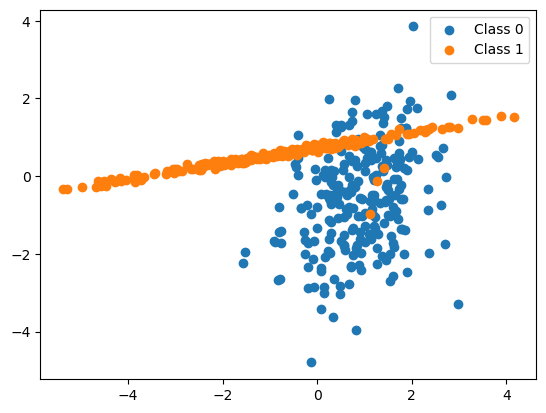

In [41]:
# Plot the data using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
for c in np.unique(y):
    plt.scatter(X_pca[y==c, 0], X_pca[y==c, 1], label=f'Class {c}')
plt.legend()
plt.show()

In [42]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create circuit

In [43]:
n_qubits = X.shape[1]
print(f"Number of qubits: {n_qubits}")


Number of qubits: 4


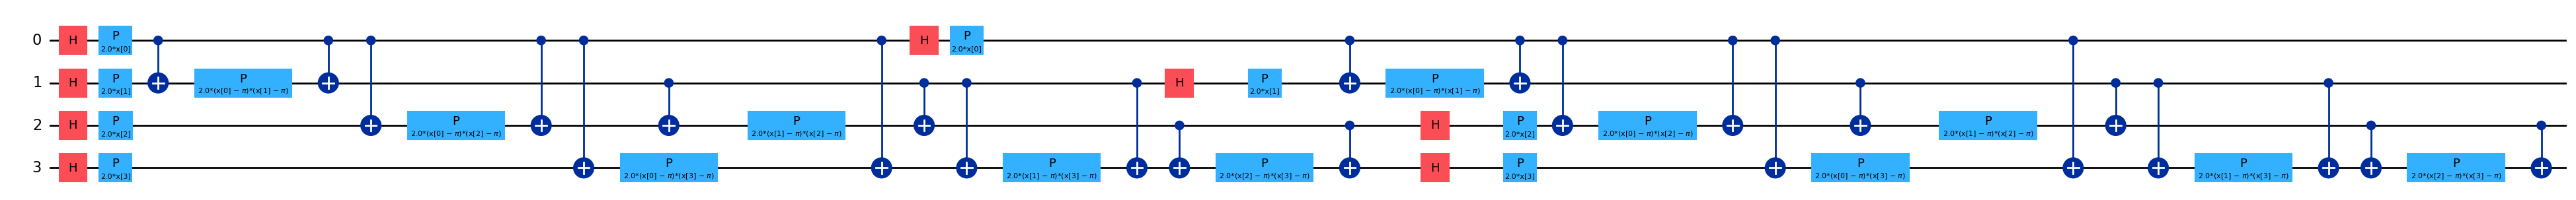

In [44]:
# Create the encoding circuit
enc_qc = zz_feature_map(n_qubits,parameter_prefix='x')

enc_qc.draw('mpl', fold=-1)

# Create QCBM

In [45]:
# Create a QCBM where:
#  -the circuit is the encoding circuit
#  -the data is data for each class
#  -the objective is to find the parameters "theta" that reproduce each class

In [46]:
import numpy as np

def float_to_nbit_bin(x, N, min_val, max_val):
    levels = 2**N
    # Clamp value to range
    x_clamped = max(min_val, min(max_val, x))
    # Normalize to [0, 1]
    normalized = (x_clamped - min_val) / (max_val - min_val)
    # Quantize
    quantized = int(round(normalized * (levels - 1)))
    # Convert to binary
    return format(quantized, f'0{N}b')

def nbit_bin_to_float(bstr, N, min_val, max_val):
    levels = 2**N
    value = int(bstr, 2)
    normalized = value / (levels - 1)
    return min_val + normalized * (max_val - min_val)


In [47]:
def encode_data_into_bitstring(X):
    """
    Encode the data into bitstrings
    """
    n_qubits = 1#X.shape[1]
    min_vals_per_col = X.min(axis=0)
    max_vals_per_col = X.max(axis=0)

    # Create an array to hold the encoded data
    X_encoded = np.zeros((X.shape[0], X.shape[1]), dtype=object)
    
    # Map each matrix point to a bitstring
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Encode each feature into a bitstring
            X_encoded[i, j] = float_to_nbit_bin(X[i, j], n_qubits, min_vals_per_col[j], max_vals_per_col[j])

    return X_encoded, min_vals_per_col, max_vals_per_col
    
def decode_bitstring_to_data(X_encoded, min_vals_per_col, max_vals_per_col):
    """
    Decode the bitstrings back to data
    """
    n_qubits = len(X_encoded[0, 0])  # Number of bits in each bitstring
    
    # Create an array to hold the decoded data
    X_decoded = np.zeros((X_encoded.shape[0], X_encoded.shape[1]))
    
    # Map each bitstring back to a matrix point
    for i in range(X_encoded.shape[0]):
        for j in range(X_encoded.shape[1]):
            # Decode each bitstring back to a feature
            X_decoded[i, j] = nbit_bin_to_float(X_encoded[i, j], n_qubits, min_vals_per_col[j], max_vals_per_col[j])

    return X_decoded

In [48]:
X_enc, min_vals_per_col, max_vals_per_col = encode_data_into_bitstring(X_train)

In [49]:
def separate_into_classes(X,y):
    """
    Separate the data into classes
    """
    unique_classes = np.unique(y)
    class_data = {}
    for c in unique_classes:
        class_data[int(c)] = X[y==c]
    return class_data

In [50]:
# Separate the data into classes
class_data = separate_into_classes(X_enc, y_train)

In [51]:
from collections import Counter
def create_prob_distribution(X_enc):
    bitstrings = []
    nums = []
    for d in X_enc:
        bitstrings += ["".join(str(int(i)) for i in d)]
        nums += [int(bitstrings[-1], 2)]
    bitstrings = np.array(bitstrings)
    nums = np.array(nums)

    # Count occurrences
    count = Counter(zip(nums, bitstrings))

    # Unique nums and bitstrings
    unique_nums = []
    unique_bitstrings = []
    probs = np.zeros(2**n_qubits)

    # Ensure counts are ordered from 000... to 1111...
    count_dict = count.items()
    count = dict(sorted(count_dict, key=lambda x: (x[0][1], x[0][0])))

    for (num, bitstring), freq in count.items():
        unique_nums.append(num)
        unique_bitstrings.append(bitstring)
        probs[num] = freq / len(X_enc)
    
    return unique_nums, unique_bitstrings, probs

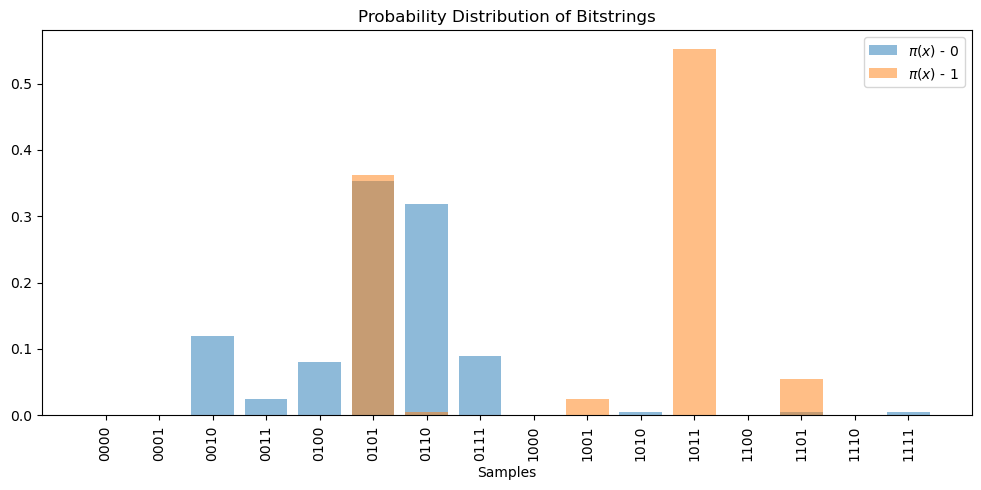

In [52]:

class_data_probs = {}
for c in class_data.keys():
    class_data_probs[c] = create_prob_distribution(class_data[c])


# Plot class 0
unique_nums0, unique_bitstrings0, probs0 = class_data_probs[0]
unique_nums1, unique_bitstrings1, probs1 = class_data_probs[1]
plt.figure(figsize=(12, 5))
plt.bar(np.arange(2**n_qubits), probs0, label=r"$\pi(x)$ - 0", alpha=0.5)
plt.bar(np.arange(2**n_qubits), probs1, label=r"$\pi(x)$ - 1", alpha=0.5)
plt.xticks(np.arange(2**n_qubits), [f"{i:0{n_qubits}b}" for i in range(2**n_qubits)], rotation=90)
plt.legend()

plt.title("Probability Distribution of Bitstrings")
plt.xlabel("Samples")
plt.show()

In [53]:
from qiskit_ibm_runtime import Sampler
from qiskit_aer import AerSimulator

def run_sampler(pubs, shots):
    backend = AerSimulator()
    sampler = Sampler(mode=backend, options={'default_shots': shots})

    job = sampler.run(pubs)
    return job.result()

In [54]:
import tqdm
from scipy.optimize import minimize, OptimizeResult
from QCBM_utils import mmd_loss
def train_qcbm(qc, target_probs, x0):

    # Define the objective function to minimize
    def objective_function(theta):
        # Create the quantum circuit with the given parameters
        qc_assigned = qc.assign_parameters(theta, inplace=False)
        qc_assigned.measure_all(inplace=True)
        
        # Simulate the circuit
        shots = 10000
        pubs = [(qc_assigned)]
        result = run_sampler(pubs, shots)
        counts = result[0].data.meas.get_counts()

        # Get the probabilities of the bitstrings
        probs = np.zeros(2**n_qubits)
        for i in range(2**n_qubits):
            bitstring = format(i, f'0{n_qubits}b')
            if bitstring in counts:
                probs[i] = counts[bitstring] / shots
            else:
                probs[i] = 0.0

        # Compute the loss
        return mmd_loss(probs, target_probs)
    # Use a classical optimizer to minimize the objective function

    # Callback
    i_results = []
    maxfev = 400
    pr_bar = tqdm.tqdm(total=maxfev, desc="Training", position=0, leave=True)
    def callback(intermediate_result: OptimizeResult):
        i_results.append(intermediate_result.fun)
        pr_bar.update(1)

    # Optimizer
    optimizer = 'COBYQA'
    result = minimize(objective_function,
                    x0.copy(),
                    method=optimizer,
                    options={'maxfev': maxfev},
                    callback=callback)

    print("Final result:")
    print(result)
    final_parameters = result.x
    final_loss = result.fun

    return final_parameters, final_loss, i_results
    

Training QCBM for class 0
Target probs for 0:
[0.         0.         0.11940299 0.02487562 0.07960199 0.35323383
 0.31840796 0.08955224 0.         0.         0.00497512 0.
 0.         0.00497512 0.         0.00497512]


Training:  20%|█▉        | 79/400 [00:10<00:44,  7.21it/s]


Final result:
 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: 0.22580940804262628
       x: [-1.885e+00  5.708e+00  2.956e+00  1.298e+00]
     nit: 45
   maxcv: 0.0
    nfev: 79
Final loss for class 0: 0.22580940804262628
Training QCBM for class 1
Target probs for 1:
[0.         0.         0.         0.         0.         0.36180905
 0.00502513 0.         0.         0.02512563 0.         0.55276382
 0.         0.05527638 0.         0.        ]


Training:  21%|██        | 84/400 [00:10<00:40,  7.88it/s]


Final result:
 message: The lower bound for the trust-region radius has been reached
 success: True
  status: 0
     fun: 0.37121640411871937
       x: [-2.646e+00  5.384e+00  3.013e+00  1.366e+00]
     nit: 48
   maxcv: 0.0
    nfev: 84
Final loss for class 1: 0.37121640411871937


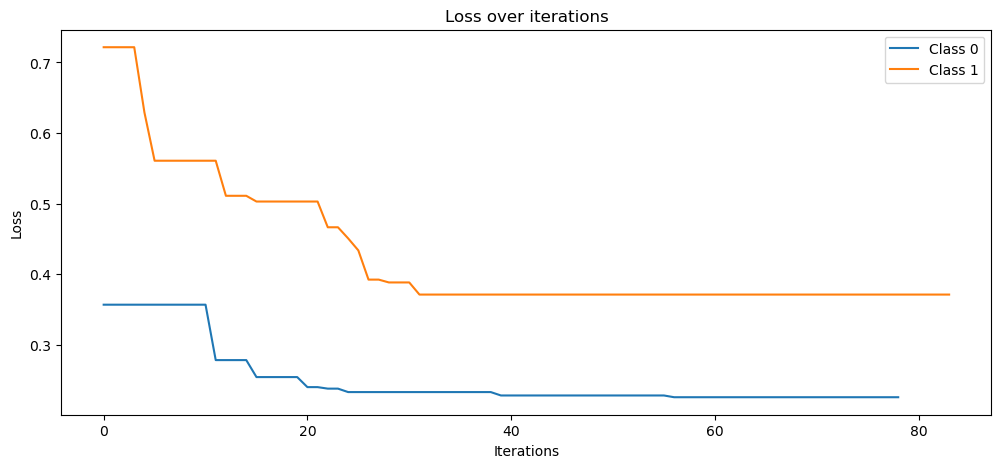

In [55]:
best_x_list = []
lost_i_res_list = []
prob_list = [probs0, probs1]
for cls in range(len(prob_list)):
    print(f"Training QCBM for class {cls}")

    target_probs = prob_list[cls]
    print(f"Target probs for {cls}:")
    print(target_probs)
    np.random.seed(42)
    # Initial point for the optimization
    initial_point = np.random.rand(enc_qc.num_parameters) * 4 * np.pi -(2 * np.pi)
    # Train the QCBM
    final_parameters, final_loss, i_results = train_qcbm(enc_qc, target_probs, initial_point)
    print(f"Final loss for class {cls}: {final_loss}")

    best_x_list.append(final_parameters)
    lost_i_res_list.append(i_results)
# Plot the loss over iterations
plt.figure(figsize=(12, 5))
plt.plot(lost_i_res_list[0], label='Class 0')
plt.plot(lost_i_res_list[1], label='Class 1')
plt.title("Loss over iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [56]:
print("Final parameters for class 0:")
print(best_x_list[0])
print("Final parameters for class 1:")
print(best_x_list[1])

Final parameters for class 0:
[-1.88546503  5.70780058  2.95646052  1.29784624]
Final parameters for class 1:
[-2.64580286  5.38422618  3.01334126  1.36640479]


In [57]:
# test with sampler
def run_qcbm(qc, params):
    # Create the quantum circuit with the given parameters
    qc_assigned = qc.assign_parameters(params, inplace=False)
    qc_assigned.measure_all()
    
    # Simulate the circuit
    shots = 10000
    pubs = [(qc_assigned)]
    result = run_sampler(pubs, shots)
    counts = result[0].data.meas.get_counts()
    # Convert counts to probabilities
    total_counts = sum(counts.values())
    probs = np.zeros(2**n_qubits)
    for i in range(2**n_qubits):
        i_in_binary = format(i, f'0{n_qubits}b')
        if i_in_binary in counts:
            probs[i] = counts[i_in_binary] / total_counts
        else:
            probs[i] = 0.0

    return probs

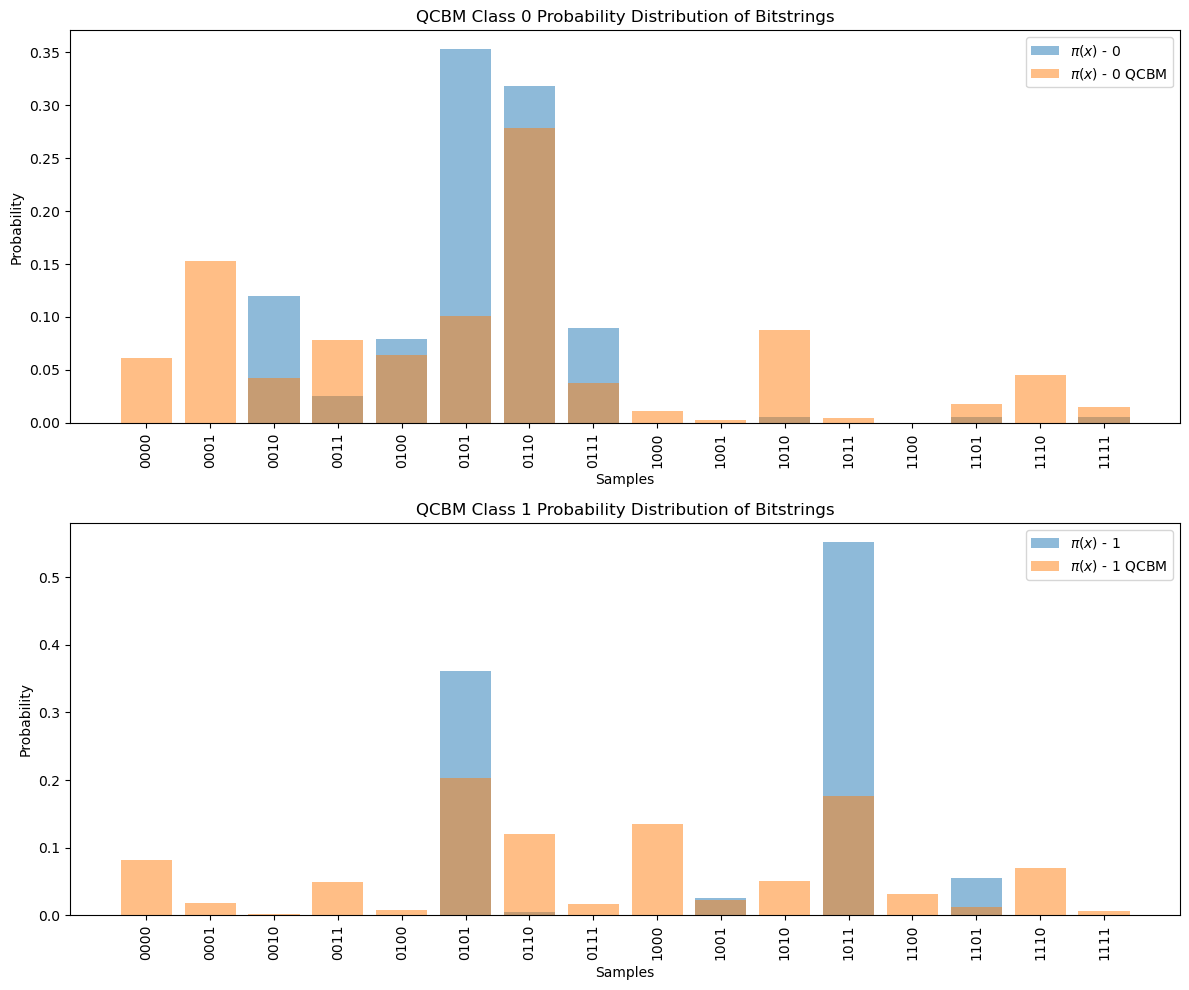

In [58]:
# Plot original distributions and QCBM distributions
qcbm_cls_0 = run_qcbm(enc_qc, best_x_list[0])
qcbm_cls_1 = run_qcbm(enc_qc, best_x_list[1])
fig, ax = plt.subplots(2, 1, figsize=(12, 10))
ax[0].bar(np.arange(2**n_qubits), probs0, label=r"$\pi(x)$ - 0", alpha=0.5)
ax[0].bar(np.arange(2**n_qubits), qcbm_cls_0, label=r"$\pi(x)$ - 0 QCBM", alpha=0.5)
ax[0].set_xticks(np.arange(2**n_qubits))
ax[0].set_xticklabels([f"{i:0{n_qubits}b}" for i in range(2**n_qubits)], rotation=90)
ax[0].legend()
ax[0].set_title("QCBM Class 0 Probability Distribution of Bitstrings")
ax[0].set_xlabel("Samples")
ax[0].set_ylabel("Probability")
ax[1].bar(np.arange(2**n_qubits), probs1, label=r"$\pi(x)$ - 1", alpha=0.5)
ax[1].bar(np.arange(2**n_qubits), qcbm_cls_1, label=r"$\pi(x)$ - 1 QCBM", alpha=0.5)
ax[1].set_xticks(np.arange(2**n_qubits))
ax[1].set_xticklabels([f"{i:0{n_qubits}b}" for i in range(2**n_qubits)], rotation=90)
ax[1].legend()
ax[1].set_title("QCBM Class 1 Probability Distribution of Bitstrings")
ax[1].set_xlabel("Samples")
ax[1].set_ylabel("Probability")
plt.tight_layout()
plt.show()



# Create kernel

In [59]:
from qiskit.quantum_info import Statevector, SparsePauliOp

def define_0s_fidelity_operator(n_qubits):
    """
    Define the fidelity operator based on the target state.

    Args:
        n_qubits (int): The number of qubits.

    Returns:
        SparsePauliOp: The fidelity operator.
    """
    statevector = Statevector.from_label('0' * n_qubits)
    operator = statevector.to_operator()
    # Convert the operator to a SparsePauliOp
    return SparsePauliOp.from_operator(operator)

In [60]:
from qiskit_ibm_runtime import Estimator
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, SparsePauliOp

def run_estimator(pubs, shots):
    backend = AerSimulator()
    estimator = Estimator(mode=backend, options={'default_shots': shots})

    job = estimator.run(pubs)
    return job.result()

In [61]:
# Kernel is ComputeUncompute
def kernel(X1, X2):
    """Compute the kernel between two sets of data points."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pubs = [(qc, fidelity_operator)]
    # Run the estimator to get the fidelity
    shots = 1024
    result = run_estimator(pubs, shots)
    fidelity = result[0].data.evs.tolist()
    return fidelity


In [62]:
import tqdm
# Compute the kernel matrix
def compute_kernel_matrix(X):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    progress_bar = tqdm.tqdm(total=n_samples * n_samples, desc="Computing kernel matrix")
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = kernel(X[i], X[j])
            progress_bar.update(1)
    progress_bar.close()
    return K

def compute_test_kernel_matrix(X_train, X_test):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X_test.shape[0]
    K = np.zeros((n_samples, X_train.shape[0]))
    progress_bar = tqdm.tqdm(total=n_samples * X_train.shape[0], desc="Computing kernel matrix")
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            K[i, j] = kernel(X_test[i], X_train[j])
            progress_bar.update(1)
    progress_bar.close()
    return K

In [63]:
def create_kernel_pub(X1, X2):
    """Create the kernel public key."""
    # Create 2 copies of the encoding circuit
    enc_qc1 = enc_qc.copy()
    enc_qc2 = enc_qc.copy()
    # Bind the parameters of the encoding circuit to the data points
    assigned_enc_1 = enc_qc1.assign_parameters(X1, inplace=False)
    assigned_enc_2 = enc_qc2.assign_parameters(X2, inplace=False)
    # Make dagger of the second circuit
    assigned_enc_2 = assigned_enc_2.inverse()
    # Create a quantum circuit that applies the encoding circuit to the data points
    qc = assigned_enc_1.compose(assigned_enc_2, inplace=False)
    # Define the fidelity operator
    fidelity_operator = define_0s_fidelity_operator(n_qubits)
    pub = (qc, fidelity_operator)
    return pub
def compute_kernel_matrix_batch(X):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X.shape[0]
    K = np.zeros((n_samples, n_samples))
    pubs = []
    for i in range(n_samples):
        for j in range(n_samples):
            pub = create_kernel_pub(X[i], X[j])
            pubs.append(pub)
    # Run the estimator
    shots = 1024
    results = run_estimator(pubs, shots)
    for i in range(n_samples):
        for j in range(n_samples):
            K[i, j] = results[i * n_samples + j].data.evs.tolist()
    return K
def compute_test_kernel_matrix_batch(X_train, X_test):
    """Compute the kernel matrix for a set of data points."""
    n_samples = X_test.shape[0]
    K = np.zeros((n_samples, X_train.shape[0]))
    pubs = []
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            pub = create_kernel_pub(X_test[i], X_train[j])
            pubs.append(pub)
    # Run the estimator
    shots = 1024
    results = run_estimator(pubs, shots)
    for i in range(n_samples):
        for j in range(X_train.shape[0]):
            K[i, j] = results[i * X_train.shape[0] + j].data.evs.tolist()
    return K

In [64]:
# Evaluate the test
class_0_test_pred = compute_test_kernel_matrix_batch(X_test, np.array([best_x_list[0]]))[0]
class_1_test_pred = compute_test_kernel_matrix_batch(X_test, np.array([best_x_list[1]]))[0]

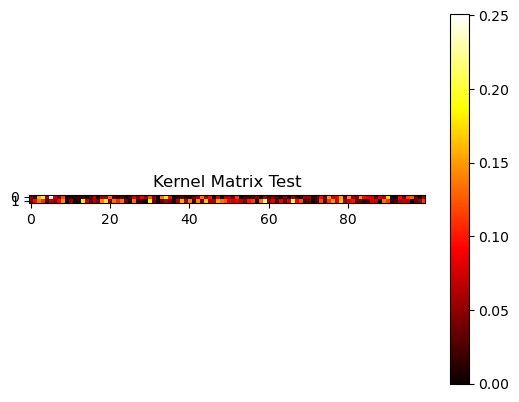

In [65]:
# Combine the y_pred, class_0_test_pred and class_1_test_pred are the probabilities of 0 and 1 respectively
y_pred_proba = np.array([[class_0_test_pred[i], class_1_test_pred[i]] for i in range(class_0_test_pred.shape[0])])
# Plot the kernel matrix
plt.imshow(y_pred_proba.T, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Kernel Matrix Test')
plt.show()

In [66]:
# Make a SVC whose support vectors are the QCBM parameters
sup_vectors = np.array([best_x_list[0], best_x_list[1]])

from sklearn.svm import _libsvm as libsvm

y_pred = libsvm.predict(
            X=y_pred_proba,
            support = np.array([0, 1], dtype=np.int32),
            SV =sup_vectors,
            nSV=np.array([1, 1], dtype=np.int32),
            sv_coef=np.array([[0.5, -0.5]], dtype=np.float64),
            intercept=np.array([0.0], dtype=np.float64),
            svm_type=0,
            kernel="precomputed"
        )


In [67]:
y_pred_2 = np.argmax(y_pred_proba, axis=1)

In [68]:
# check if y_pred and y_pred_2 are the same
print(np.all(y_pred == y_pred_2))

False


In [69]:
# Print the classification report
clas_rep = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred, target_names=[f'Class {i}' for i in range(n_classes)]))

              precision    recall  f1-score   support

     Class 0       0.50      0.48      0.49        46
     Class 1       0.57      0.59      0.58        54

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.54       100
weighted avg       0.54      0.54      0.54       100



# Optimize coeffs and intercept

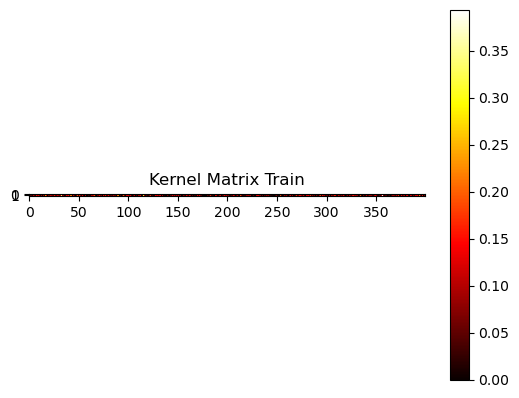

In [70]:
y_pred_train_kernel_0 = compute_test_kernel_matrix_batch(X_train, np.array([best_x_list[0]]))[0]
y_pred_train_kernel_1 = compute_test_kernel_matrix_batch(X_train, np.array([best_x_list[1]]))[0]
# Combine the y_pred
y_pred_train_kernel = np.array([[y_pred_train_kernel_0[i], y_pred_train_kernel_1[i]] for i in range(y_pred_train_kernel_0.shape[0])])
# Plot the kernel matrix
plt.imshow(y_pred_train_kernel.T, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Kernel Matrix Train')
plt.show()


In [71]:
from scipy.optimize import minimize
import numpy as np
from sklearn.svm import _libsvm as libsvm

# Fixed inputs
support = np.array([0, 1], dtype=np.int32)
SV = sup_vectors  # your 2 support vectors
nSV = np.array([1, 1], dtype=np.int32)

def objective(params):
    
    coef1, coef2, intercept = params
    sv_coef = np.array([[coef1, coef2]], dtype=np.float64)
    b = np.array([intercept], dtype=np.float64)

    try:
        y_score = libsvm.predict(
            X=y_pred_train_kernel,
            support=support,
            SV=SV,
            nSV=nSV,
            sv_coef=sv_coef,
            intercept=b,
            svm_type=0,
            kernel="precomputed"
        )
        return log_loss(y_train, y_score)  # or any other metric you want to optimize
        #return - f1_score(y_train, y_score, average='weighted')  # or any other metric you want to optimize
    except Exception:
        return np.inf  # in case libsvm errors out, return bad score

svm_i_results = []
def callback_svm(intermediate_result):
    if isinstance(intermediate_result, OptimizeResult):
        svm_i_results.append(intermediate_result.fun)
    else:
        pass

initial_guess = [0.5, -0.5, 0.0]
optimizer = 'COBYLA'
maxfev = 10000
res = minimize(objective,
               initial_guess,
               method=optimizer,
               options={'maxfev': 10000},
               tol=0,
               callback=callback_svm)

c:\Users\danel.a.a\AppData\Local\anaconda3\envs\qkbc\Lib\site-packages\scipy\optimize\_minimize.py:744: OptimizeWarning: Unknown solver options: maxfev
  res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,


In [72]:
best_coef1, best_coef2, best_intercept = res.x
print("Optimized sv_coef:", [best_coef1, best_coef2])
print("Optimized intercept:", best_intercept)

Optimized sv_coef: [np.float64(0.4743860364260853), np.float64(-0.49670276448153977)]
Optimized intercept: 0.012309485552407878


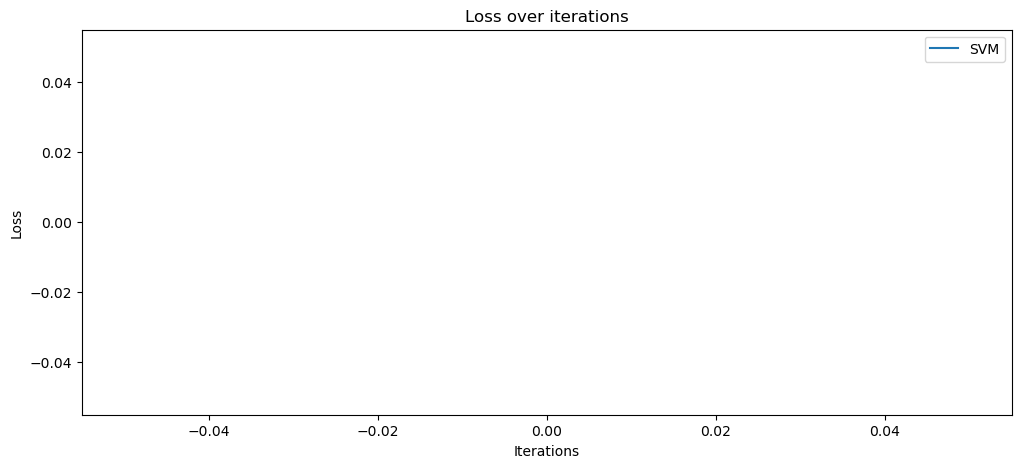

In [73]:
# Plot the loss over iterations
plt.figure(figsize=(12, 5))
plt.plot(svm_i_results, label='SVM')
plt.title("Loss over iterations")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [74]:
# Make prediction of test
y_pred_test_2 = libsvm.predict(
            X=y_pred_proba,
            support = np.array([0, 1], dtype=np.int32),
            SV =sup_vectors,
            nSV=np.array([1, 1], dtype=np.int32),
            sv_coef=np.array([[best_coef1, best_coef2]], dtype=np.float64),
            intercept=np.array([best_intercept], dtype=np.float64),
            svm_type=0,
            kernel="precomputed"
        )
# Print the classification report 
cls_rep_fin = classification_report(y_test, y_pred_test_2, output_dict=True)
print(classification_report(y_test, y_pred_test_2, target_names=[f'Class {i}' for i in range(n_classes)]))


              precision    recall  f1-score   support

     Class 0       0.51      0.57      0.54        46
     Class 1       0.59      0.54      0.56        54

    accuracy                           0.55       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.55      0.55      0.55       100

